<a href="https://colab.research.google.com/github/m-ourt/DepoTP/blob/master/Detection_Malicious_URL_Using_ML_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credits

Notebook taken from following link: https://www.kaggle.com/code/hamzamanssor/detection-malicious-url-using-ml-models

All rights belong to original author.

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sid321axn_malicious_urls_dataset_path = kagglehub.dataset_download('sid321axn/malicious-urls-dataset')

print('Data source import complete.')


Using Colab cache for faster access to the 'malicious-urls-dataset' dataset.
Data source import complete.


# Detection Malicious URL Using ML Models

A URL consists of the top-level domain, hostname, paths, and port of the web
address, as in the following diagram:

![url](https://user-images.githubusercontent.com/70811337/150021474-4ba64b34-1d09-427f-9cf6-25508571d18d.PNG)

<h2 style="width: 100%;
    margin: 0;
    padding: 0;
    text-align: center;">---- Table of contents ----</h2>

1. [Importing Libraries](#1)
2. [Load Dataset](#2)
3. [Meta information of Dataframe](#3)
4. [Checking for NaN values](#4)
5. [Feature Extraction](#5)
6. [Train & Test Split](#6)
7. [Training models](#7)
  <ul>
      <li>✔️ Decision Tree Classifier</li>
      <li>✔️ Random Forest Classifier</li>
      <li>✔️ AdaBoost Classifier</li>
      <li>✔️ KNeighbors Classifier</li>
      <li>✔️ SGD Classifier</li>
      <li>✔️ Extra Trees Classifier</li>
      <li>✔️ Gaussian NB</li>
  </ul>
8. [Final Report](#8)

In [ ]:
pip install tld

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.7/274.7 kB 8.3 MB/s eta 0:00:00


<a id="1"></a> <br>
# 📥 Importing Libraries

In [ ]:
!pip install colorama
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from tld import get_tld, is_tld

<a id="2"></a> <br>
# 🗃️ Load Dataset

In [ ]:
ls

sample_data/


In [ ]:
sid321axn_malicious_urls_dataset_path

'/root/.cache/kagglehub/datasets/sid321axn/malicious-urls-dataset/versions/1'

In [ ]:
data = pd.read_csv(sid321axn_malicious_urls_dataset_path + '/malicious_phish.csv')
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


<a id="3"></a> <br>
# 📝 Meta information of Dataframe

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


<a id="4"></a>
# 🔎 Checking for NaN values

In [ ]:
data.isnull().sum()

,0
url,0
type,0


In [ ]:
count = data.type.value_counts()
count

,count
type,
benign,428103
defacement,96457
phishing,94111
malware,32520


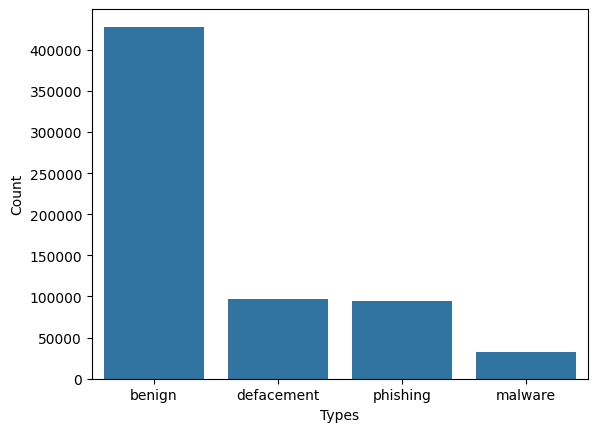

In [ ]:
sns.barplot(x=count.index, y=count)
plt.xlabel('Types')
plt.ylabel('Count');

<h4>first have to omit the (www.) from the URL which is in fact a sub domain in itself.</h4>

In [ ]:
data['url'] = data['url'].replace('www.', '', regex=True)
data

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [ ]:
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [ ]:
rem = {"Category": {"benign": 0, "defacement": 1, "phishing":2, "malware":3}}
data['Category'] = data['type']
data = data.replace(rem)

/tmp/ipython-input-1624019599.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace(rem)


<a id="5"></a> <br>
# 🦾 Feature Extraction

In [ ]:
data['url_len'] = data['url'].apply(lambda x: len(str(x)))

In [ ]:
def process_tld(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain

In [ ]:
data['domain'] = data['url'].apply(lambda i: process_tld(i))

In [ ]:
data.head()

,url,type,Category,url_len,domain
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net


In [ ]:
feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for a in feature:
    data[a] = data['url'].apply(lambda i: i.count(a))

In [ ]:
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,#,%,+,$,!,*,",",//
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,0,0,0,0,0,0,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1


In [ ]:
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [ ]:
data['abnormal_url'] = data['url'].apply(lambda i: abnormal_url(i))

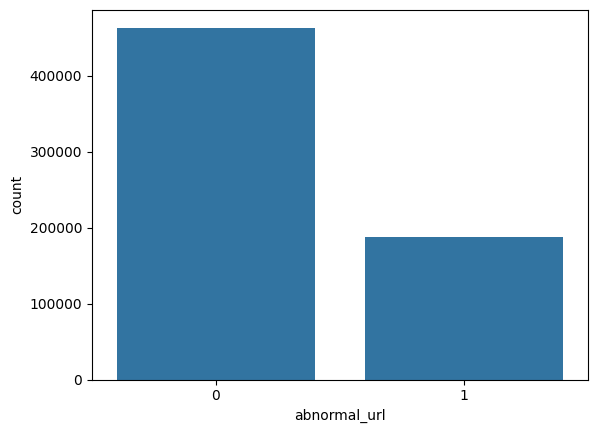

In [ ]:
sns.countplot(x='abnormal_url', data=data);

In [ ]:
def httpSecure(url):
    htp = urlparse(url).scheme
    match = str(htp)
    if match=='https':
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [ ]:
data['https'] = data['url'].apply(lambda i: httpSecure(i))

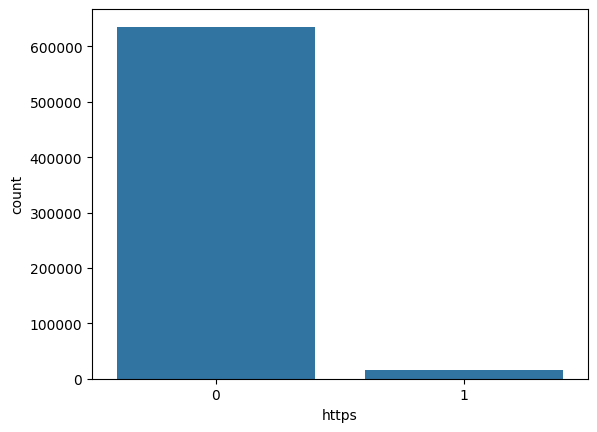

In [ ]:
sns.countplot(x='https', data=data);

<h4>Counts the number of digit characters in a URL</h4>

In [ ]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

In [ ]:
data['digits']= data['url'].apply(lambda i: digit_count(i))

<h4>Counts the number of letter characters in a URL</h4>

In [ ]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

In [ ]:
data['letters']= data['url'].apply(lambda i: letter_count(i))

<h4>Checks to see whether URL contains a shortening service</h4>

In [ ]:
def Shortining_Service(url):
    match = re.search(r'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      r'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      r'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      r'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      r'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      r'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      r'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      r'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

In [ ]:
data['Shortining_Service'] = data['url'].apply(lambda x: Shortining_Service(x))

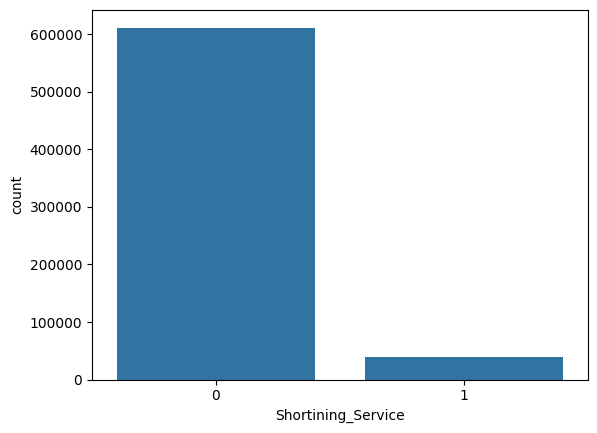

In [ ]:
sns.countplot(x='Shortining_Service', data=data);

In [ ]:
def having_ip_address(url):
    match = re.search(
        r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.'
        r'([01]?\d\d?|2[0-4]\d|25[0-5])\/)|'  # IPv4
        r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.'
        r'([01]?\d\d?|2[0-4]\d|25[0-5])\/)|'  # IPv4 with port
        r'((0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\/)' # IPv4 in hexadecimal
        r'(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        r'([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        r'((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

In [ ]:
data['having_ip_address'] = data['url'].apply(lambda i: having_ip_address(i))

In [ ]:
data['having_ip_address'].value_counts()

,count
having_ip_address,
0,638703
1,12488


<Axes: >

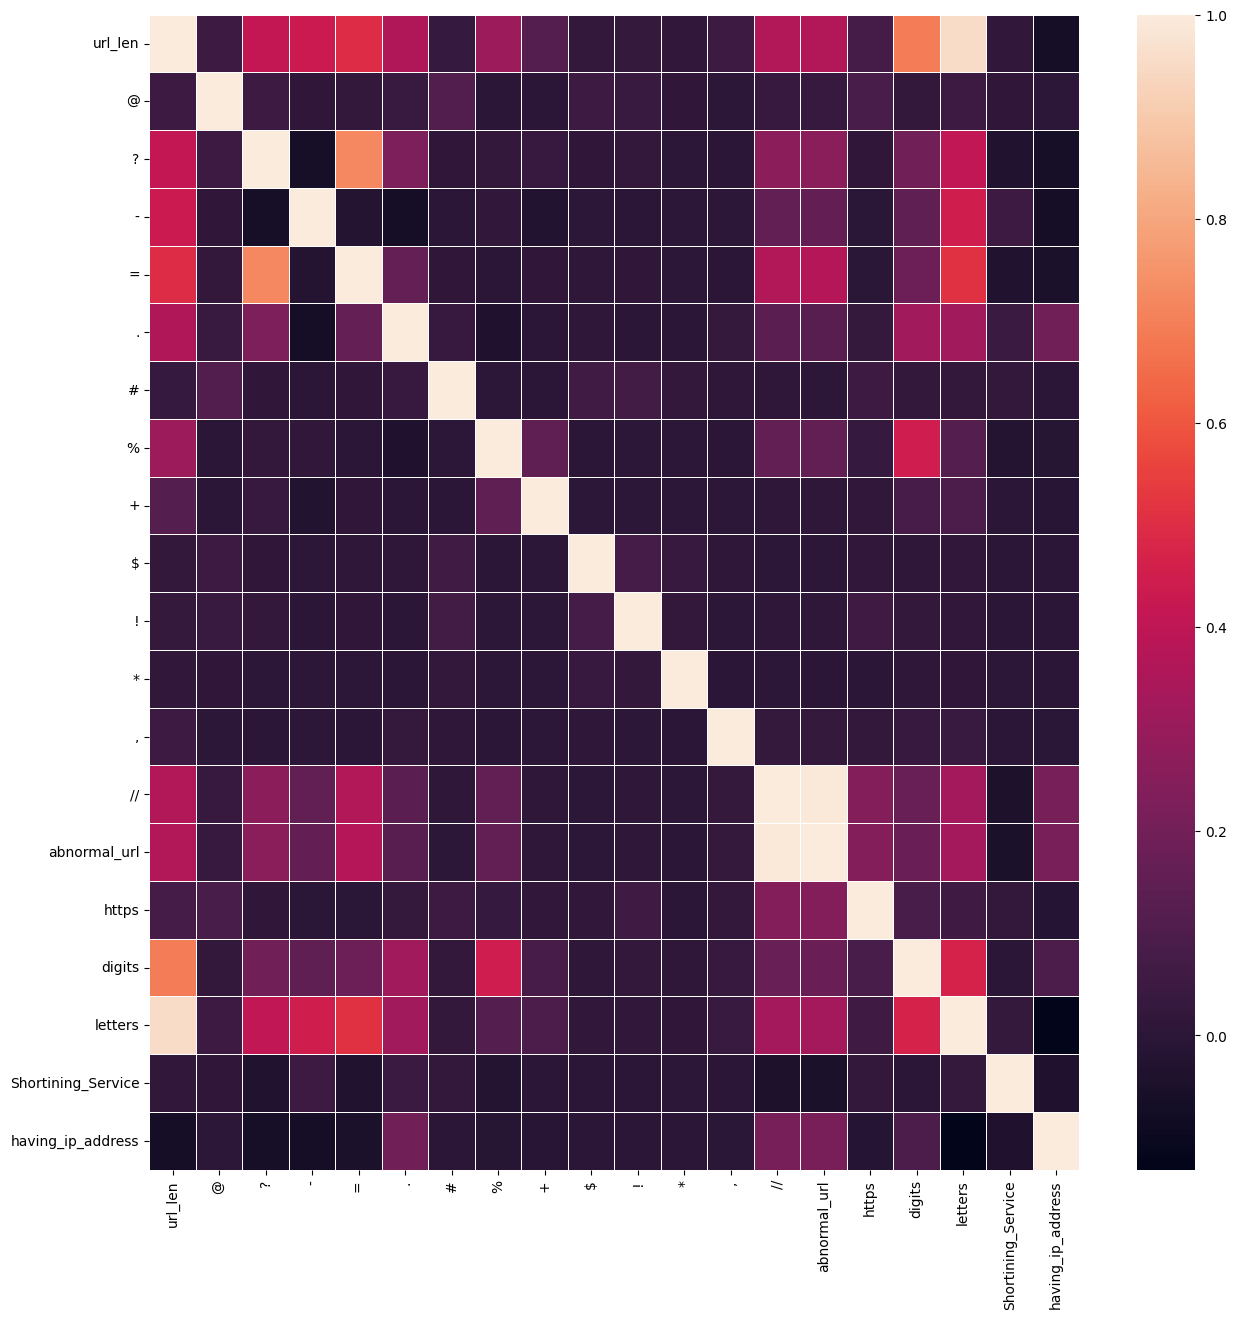

In [ ]:
X = data.drop(['url','type','Category','domain'],axis=1)#,'type_code'
y = data['Category']
plt.figure(figsize=(15, 15))
sns.heatmap(X.corr(), linewidths=.5)

<a id="6"></a> <br>
# ✂️ Train & Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

<a id="7"></a> <br>
# <img src="https://cdn-icons-png.flaticon.com/32/4149/4149680.png"/> Training models


#############################################
######- Model: DecisionTreeClassifier -######
Test Accuracy: 90.94%

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     85565
           1       0.93      0.96      0.95     19319
           2       0.80      0.57      0.66     18805
           3       0.95      0.91      0.93      6550

    accuracy                           0.91    130239
   macro avg       0.90      0.85      0.87    130239
weighted avg       0.90      0.91      0.90    130239


Confusion Matrix:


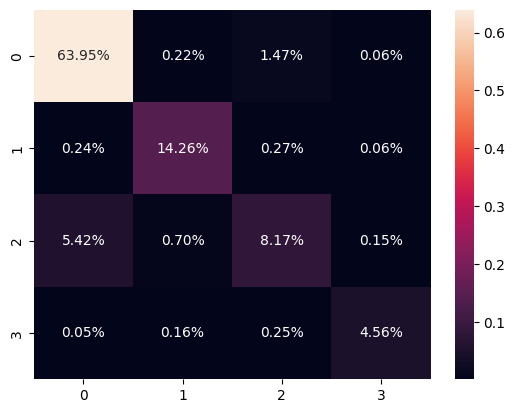

#############################################


#############################################
######- Model: RandomForestClassifier -######
Test Accuracy: 91.49%

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     85565
           1       0.94      0.97      0.95     19319
           2       0.83      0.57      0.68     18805
           3       0.96      0.91      0.93      6550

    accuracy                           0.91    130239
   macro avg       0.91      0.86      0.88    130239
weighted avg       0.91      0.91      0.91    130239


Confusion Matrix:


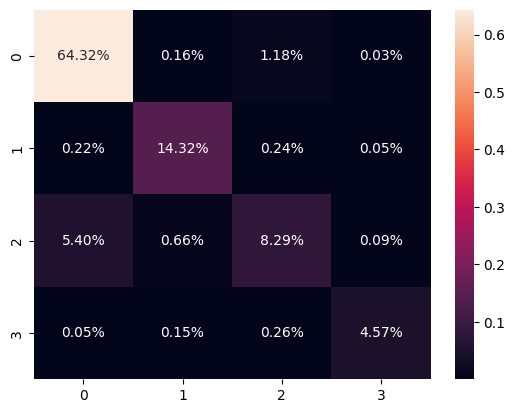

#############################################


#############################################
######- Model: AdaBoostClassifier -######
Test Accuracy: 79.95%

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90     85565
           1       0.66      0.96      0.78     19319
           2       0.31      0.03      0.05     18805
           3       0.85      0.49      0.62      6550

    accuracy                           0.80    130239
   macro avg       0.67      0.61      0.59    130239
weighted avg       0.74      0.80      0.74    130239


Confusion Matrix:


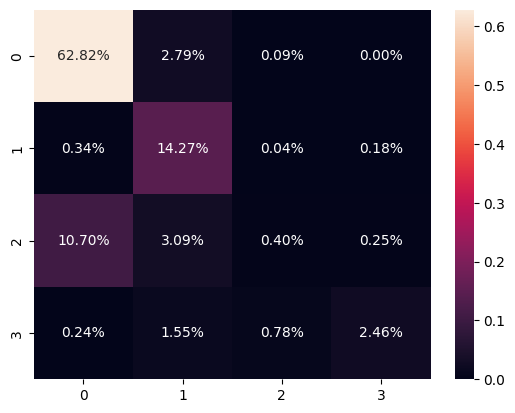

#############################################


#############################################
######- Model: KNeighborsClassifier -######
Test Accuracy: 88.85%

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     85565
           1       0.89      0.95      0.92     19319
           2       0.72      0.53      0.61     18805
           3       0.94      0.88      0.91      6550

    accuracy                           0.89    130239
   macro avg       0.87      0.83      0.84    130239
weighted avg       0.88      0.89      0.88    130239


Confusion Matrix:


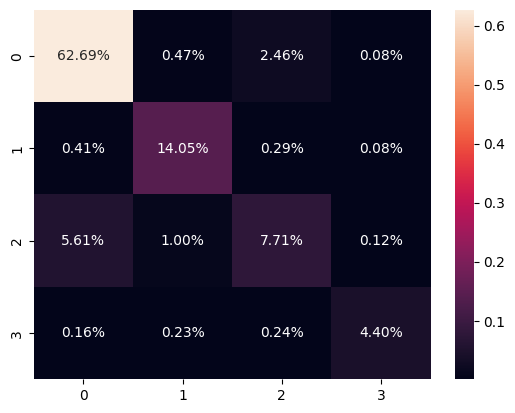

#############################################


#############################################
######- Model: SGDClassifier -######
Test Accuracy: 81.48%

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.99      0.90     85565
           1       0.80      0.86      0.83     19319
           2       0.54      0.02      0.04     18805
           3       0.82      0.63      0.71      6550

    accuracy                           0.81    130239
   macro avg       0.75      0.63      0.62    130239
weighted avg       0.78      0.81      0.75    130239


Confusion Matrix:


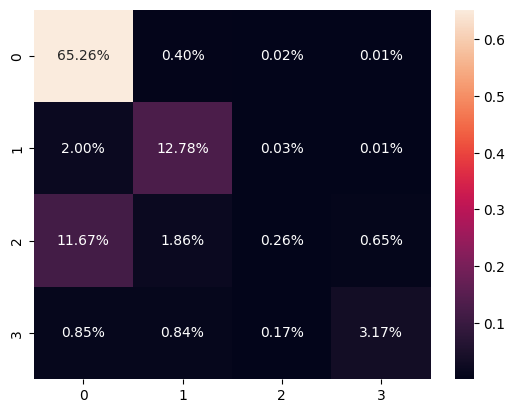

#############################################


#############################################
######- Model: ExtraTreesClassifier -######
Test Accuracy: 91.47%

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     85565
           1       0.93      0.97      0.95     19319
           2       0.83      0.57      0.68     18805
           3       0.97      0.91      0.94      6550

    accuracy                           0.91    130239
   macro avg       0.91      0.86      0.88    130239
weighted avg       0.91      0.91      0.91    130239


Confusion Matrix:


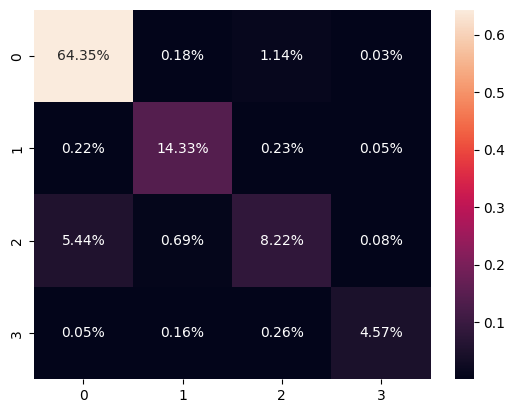

#############################################


#############################################
######- Model: GaussianNB -######
Test Accuracy: 78.95%

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88     85565
           1       0.66      1.00      0.79     19319
           2       0.60      0.02      0.04     18805
           3       0.61      0.70      0.65      6550

    accuracy                           0.79    130239
   macro avg       0.68      0.66      0.59    130239
weighted avg       0.77      0.79      0.74    130239


Confusion Matrix:


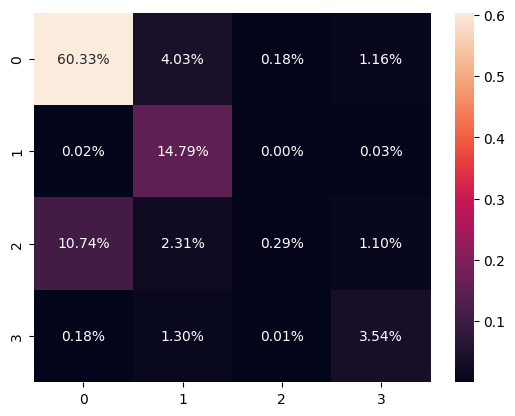

#############################################



In [ ]:
models = [
    DecisionTreeClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    KNeighborsClassifier,
    SGDClassifier,
    ExtraTreesClassifier,
    GaussianNB
]

accuracy_test = []

for model_class in models:
    print(f'\n{'#'*45}')
    print(f'######- Model: {model_class.__name__} -######')

    # Initialize and train the model
    model_instance = model_class()
    model_instance.fit(X_train, y_train)

    # Make predictions and calculate accuracy
    predictions = model_instance.predict(X_test)
    accuracy = accuracy_score(predictions, y_test)
    accuracy_test.append(accuracy)

    print(f'Test Accuracy: {accuracy*100:.2f}%')

    # Print classification report
    print('\nClassification Report:')
    print(classification_report(y_test, predictions))

    # Plot confusion matrix
    print('\nConfusion Matrix:')
    cf_matrix = confusion_matrix(y_test, predictions)
    sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, fmt='0.2%')
    plt.show()
    print(f'{'#'*45}\n')


<a id="8"></a> <br>
# <img src="https://cdn-icons-png.flaticon.com/64/3094/3094836.png"/> Final Report

In [ ]:
output = pd.DataFrame({"Model":['Decision Tree Classifier',
                                'Random Forest Classifier',
                                'AdaBoost Classifier',
                                'KNeighbors Classifier',
                                'SGD Classifier',
                                'Extra Trees Classifier',
                                'Gaussian NB'],
                      "Accuracy":accuracy_test})

In [ ]:
output

,Model,Accuracy
0,Decision Tree Classifier,0.909436
1,Random Forest Classifier,0.914949
2,AdaBoost Classifier,0.799499
3,KNeighbors Classifier,0.888467
4,SGD Classifier,0.814779
5,Extra Trees Classifier,0.914688
6,Gaussian NB,0.789548


<a id="9"></a> <br>
# ✨ Thanks

* Feel free to download Notebook and do experiments on it.
* Comments if you find something inappropriate and will improve accordingly.
* Upvote if you find this notebook useful.